In [10]:
from multi_arm import MultiArmedBanditEnv
from gymnasium import Space, Env
import numpy as np

probs = np.random.random(10)
env: MultiArmedBanditEnv = MultiArmedBanditEnv(probabilities=probs, seed=42)
obs: int = env.reset()
done: bool = False
total_reward: int = 0

print('Multi-armed state', env.probabilities)
while not done:
    action: int = env.action_space.sample()  # Replace this with your strategy
    obs, reward, done, info = env.step(action)
    total_reward += reward
    print(f"Action: {action}, Reward: {reward}, Total Reward: {total_reward}")

env.close()

Multi-armed state [0.19675965 0.15974396 0.20228694 0.02960614 0.50197067 0.84522324
 0.00696974 0.348043   0.77239686 0.55250837]
Action: 0, Reward: 0, Total Reward: 0
Action: 1, Reward: 0, Total Reward: 0
Action: 3, Reward: 0, Total Reward: 0
Action: 7, Reward: 1, Total Reward: 1
Action: 3, Reward: 0, Total Reward: 1
Action: 4, Reward: 0, Total Reward: 1
Action: 9, Reward: 0, Total Reward: 1
Action: 9, Reward: 0, Total Reward: 1
Action: 7, Reward: 0, Total Reward: 1
Action: 0, Reward: 0, Total Reward: 1
Action: 9, Reward: 1, Total Reward: 2
Action: 1, Reward: 1, Total Reward: 3
Action: 7, Reward: 0, Total Reward: 3
Action: 9, Reward: 0, Total Reward: 3
Action: 5, Reward: 1, Total Reward: 4
Action: 7, Reward: 0, Total Reward: 4
Action: 1, Reward: 0, Total Reward: 4
Action: 5, Reward: 1, Total Reward: 5
Action: 7, Reward: 1, Total Reward: 6
Action: 8, Reward: 1, Total Reward: 7
Action: 1, Reward: 0, Total Reward: 7
Action: 4, Reward: 1, Total Reward: 8
Action: 8, Reward: 0, Total Rewar

In [41]:
class RandomAgent:
    def __init__(self, action_space: Space) -> None:
        self.action_space = action_space

    def act(self):
        return self.action_space.sample()
    
    def update_state(self, action: int, reward: int) -> None:
        return
    
    def reset(self) -> None:
        return
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}"
    
class ExploreAndGreed:
    def __init__(self, action_space: Space, exploration_prob: float = 0.1) -> None:
        assert 0 <= exploration_prob <= 1, f'"eploration_prob" should be in [0, 1] range, current value = {exploration_prob}'
        self.exploration_prob = exploration_prob
        self.arm_num = action_space.n
        self.arm_count = np.zeros(self.arm_num)
        self.arm_reward = np.zeros(self.arm_num) 
    
    def act(self) -> int:
        # act based on current internal state

        # exploitation step
        if  np.random.random() > self.exploration_prob:
            return np.argmax(self.arm_reward / (self.arm_count + 1e-5))
        else: # exploration step
            return np.random.choice(self.arm_num)
    
    def update_state(self, action: int, reward: int) -> None:
        # update stats based on observed reward
        self.arm_count[action] += 1
        self.arm_reward[action] += reward
    
    def reset(self) -> None:
        self.arm_count = np.zeros(self.arm_num)
        self.arm_reward = np.zeros(self.arm_num) 
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(exploration_prob={self.exploration_prob})"


In [42]:
print('Multi-armed state', env.probabilities)
agent = ExploreAndGreed(env.action_space)
obs: int = env.reset()
done: bool = False
total_reward: int = 0
while not done:
    action: int = agent.act()  # Replace this with your strategy
    obs, reward, done, info = env.step(action)
    agent.update_state(action, reward)
    total_reward += reward
    print(f"Action: {action}, Reward: {reward}, Total Reward: {total_reward}")

Multi-armed state [0.91013321 0.9258565  0.66176375 0.15534345 0.81389986 0.7120641
 0.04804633 0.36629118 0.21701378 0.72270938]
Action: 0, Reward: 0, Total Reward: 0
Action: 0, Reward: 1, Total Reward: 1
Action: 0, Reward: 1, Total Reward: 2
Action: 0, Reward: 1, Total Reward: 3
Action: 7, Reward: 1, Total Reward: 4
Action: 5, Reward: 0, Total Reward: 4
Action: 7, Reward: 1, Total Reward: 5
Action: 7, Reward: 0, Total Reward: 5
Action: 0, Reward: 1, Total Reward: 6
Action: 2, Reward: 1, Total Reward: 7
Action: 2, Reward: 1, Total Reward: 8
Action: 2, Reward: 1, Total Reward: 9
Action: 6, Reward: 0, Total Reward: 9
Action: 2, Reward: 1, Total Reward: 10
Action: 2, Reward: 1, Total Reward: 11
Action: 2, Reward: 1, Total Reward: 12
Action: 2, Reward: 0, Total Reward: 12
Action: 2, Reward: 0, Total Reward: 12
Action: 0, Reward: 1, Total Reward: 13
Action: 0, Reward: 1, Total Reward: 14
Action: 0, Reward: 1, Total Reward: 15
Action: 0, Reward: 1, Total Reward: 16
Action: 0, Reward: 1, Tot

## Bernoulli testbed

In [45]:
from typing import List, Type
from gymnasium import Env
import matplotlib.pyplot as plt
from collections import defaultdict

# Define other agent classes here with an `act` method.
def run_experiment(env: Env, agent) -> np.ndarray[float]:
    # What if envs are different lengths?
    rewards = []
    _ = env.reset()
    agent.reset()
    done = False
    total_reward = 0
    while not done:
        action: int = agent.act()
        _, reward, done, _ = env.step(action)
        agent.update_state(action, reward)
        total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

def average_results(all_rewards: List[np.ndarray]) -> np.ndarray:
    summed_rewards = np.sum(np.array(all_rewards), axis=0)
    return summed_rewards / len(all_rewards)

# Experiment setup
num_experiments = 30
num_arms = 10

agents = [RandomAgent, ExploreAndGreed, ExploreAndGreed]
agents_kwargs = [
    {},
    {"exploration_prob": 0.1},
    {"exploration_prob": 0.2}
]
agent_rewards = defaultdict(list)

for exp in range(num_experiments):
    settings = np.random.random(num_arms)
    env = MultiArmedBanditEnv(probabilities=settings)
    for Agent, kwargs in zip(agents, agents_kwargs):
        agent = Agent(env.action_space, **kwargs)
        rewards = run_experiment(env, agent)
        agent_rewards[str(agent)].append(rewards)

# Average the results
average_agent_rewards = {agent: average_results(rewards) 
                         for agent, rewards in agent_rewards.items()}



In [46]:
print(agent)

ExploreAndGreed(exploration_prob=0.2)


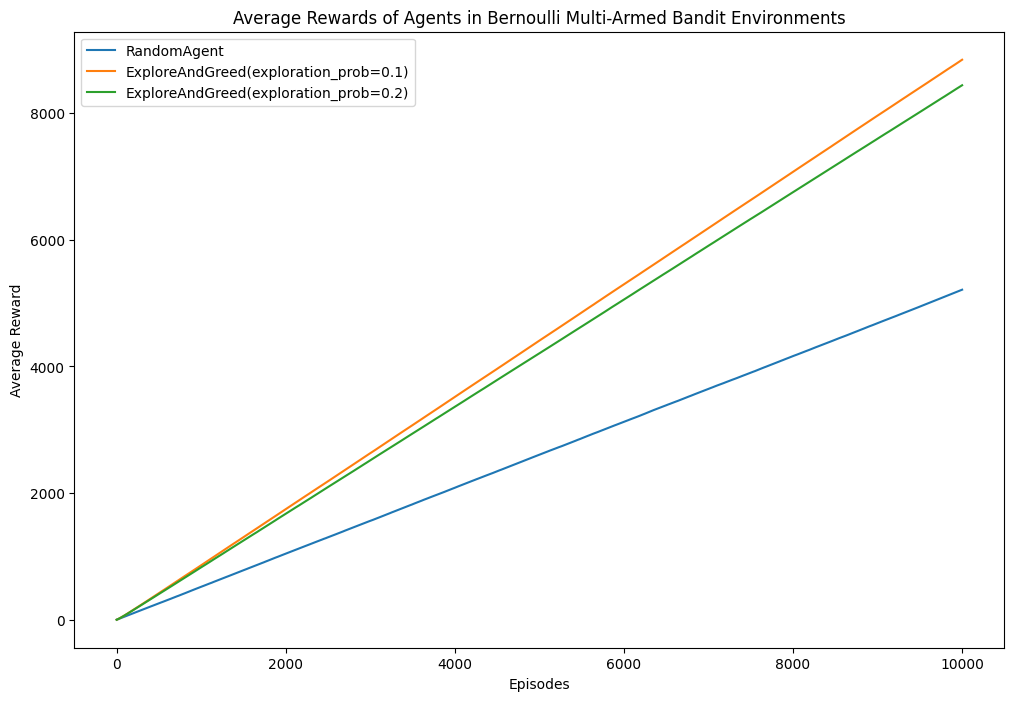

In [49]:
plt.figure(figsize=(12, 8))
for agent_name, rewards in average_agent_rewards.items():
    plt.plot(rewards, label=agent_name)

plt.title('Average Rewards of Agents in Bernoulli Multi-Armed Bandit Environments')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.show()